# Метод Рунге-Кутты (RK 4)

In [82]:
import numpy as np
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as int

In [83]:
def func(y,t):
    r = y[0:3].copy()
    v = y[3:6].copy()
    mu = 1
    return np.concatenate((v,-mu*r/np.linalg.norm(r)**3))

In [91]:
def RK4(f, x0, t0, tf , n):
    
    T = np.linspace(t0, tf, n)
    
    Y = np.empty((n,6))   
    
    Y[0] = x0
    
    h = T[1]-T[0]
    
    for i in range(n-1):
        k1 = f(Y[i], T[i])
        k2 = f(Y[i] + 0.5 *h* k1, T[i] + 0.5*h)
        k3 = f(Y[i] + 0.5 *h* k2, T[i] + 0.5*h)
        k4 = f(Y[i] + h*k3, T[i] + h) 
        Y[i+1] = Y[i] + h*(k1 + 2*(k2 + k3) + k4) / 6
        
    return Y, T


In [92]:
X0 = np.array([1,0,0,0,1,0])

In [93]:
vec, t  = RK4(func, X0, 0, 2*np.pi, 100)

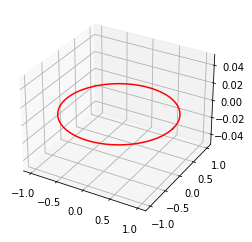

In [94]:
x=[]
y=[]
z=[]
for j in range(len(vec)):
    x.append(vec[j][0])
    y.append(vec[j][1])
    z.append(vec[j][2])

fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, 'red')

plt.show()

# Сравнение методов интегрирования scipy

In [95]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import math 

def func(t,y):
    r = y[0:3].copy()
    v = y[3:6].copy()
    mu = 1
    return np.append(v,-mu*r/np.linalg.norm(r)**3)

tspan = (0,2*np.pi)
y0 = np.array([1,0,0,0,1,0])

tol = [10**(-i) for i in range (1,17)]

In [96]:
fevs_L = []
x_L = []

fevs_RK = []
x_RK = []

fevs_DOP = []
x_DOP = []

for item in tol:
    
    res_L = solve_ivp(func, tspan, y0, method = 'LSODA', rtol = item, atol = item)
    er_L = np.linalg.norm(res_L.y[:,-1] - res_L.y[:,0])
    fevs_L.append(res_L.nfev)
    x_L.append(er_L)
    
    res_RK = solve_ivp(func, tspan, y0, method = 'RK45', rtol = item, atol = item)
    er_RK = np.linalg.norm(res_RK.y[:,-1] - res_RK.y[:,0])
    fevs_RK.append(res_RK.nfev)
    x_RK.append(er_RK)

    res_DOP = solve_ivp(func, tspan, y0, method = 'DOP853', rtol = item, atol = item)
    er_DOP = np.linalg.norm(res_DOP.y[:,-1] - res_DOP.y[:,0])
    fevs_DOP.append(res_DOP.nfev)
    x_DOP.append(er_DOP)

c:\code\test_project\venv\lib\site-packages\scipy\integrate\_ivp\common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


In [97]:
xL = np.log10(x_L)
xRK = np.log10(x_RK)
xDOP = np.log10(x_DOP)

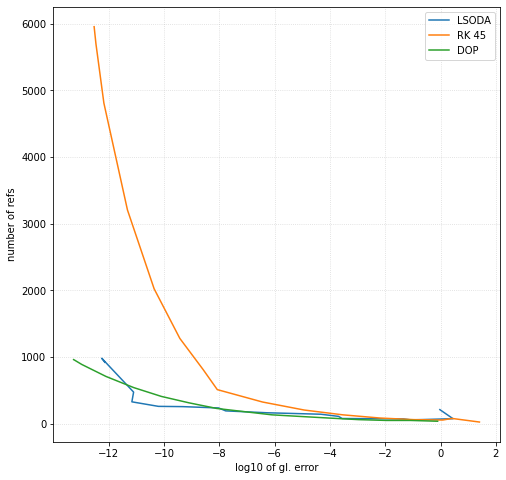

In [98]:
plt.figure(figsize=(8,8))
plt.plot(xL,fevs_L, label = 'LSODA')
plt.plot(xRK,fevs_RK, label = 'RK 45')
plt.plot(xDOP,fevs_DOP, label = 'DOP')
plt.legend()
plt.xlabel('log10 of gl. error')
plt.ylabel('number of refs')
plt.grid(True, linestyle=":", alpha=0.5)
plt.show()

# Реализация уравнения в вариациях

In [87]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [88]:
def func(t, Z):
    
    r_vec = Z[0:3]
    
    r = np.linalg.norm(r_vec)
    
    v_vec = Z[3:6]
    dydy0 = np.reshape(Z[6:42],(6,6))
    
    dfdy = np.zeros((6,6))
    dfdy[0:3,3:6] = np.eye(3)
    dfdy[3:6,0:3] = 3 * r_vec.reshape((3,1))@r_vec.reshape((1,3))/r**5 - np.eye(3)/r**3
                    
    dZdt = np.empty(42,)
    dZdt[0:3] = v_vec.copy()
    dZdt[3:6] = -r_vec/r**3
    dZdt[6:42] = np.reshape(dfdy@dydy0, (36,))
    
    return dZdt
    

In [89]:
r_vec0 = np.array([1,0,0])
v_vec0 = np.array([0,1,0])
y0 = np.append(r_vec0,v_vec0)

z0 = np.append(y0,np.reshape(np.eye(6),(36,)))
t0  = 0
tf = 2*np.pi

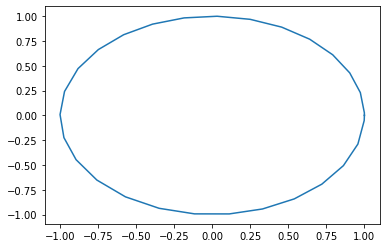

In [90]:
sol = solve_ivp(func,[t0,tf],z0,atol = 1e-6, rtol = 1e-6)
plt.plot(sol.y[0,:],sol.y[1,:])

# Интегрирование с выходом на ограничение

In [99]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [100]:
def func(t, Z):
    
    r_vec = Z[0:3]    
    r = np.linalg.norm(r_vec)    
    v_vec = Z[3:6]
                    
    dZdt = np.empty(6,)
    dZdt[0:3] = v_vec.copy()
    dZdt[3:6] = -r_vec/r**3
    
    return dZdt
    

In [101]:
r_vec0 = np.array([1,0,0])
v_vec0 = np.array([0,1,0])
y0 = np.append(r_vec0,v_vec0)

t0  = 0
tf = 2*np.pi

In [102]:
def event_func(t,z):
    return z[0]

event_func.terminal = False
event_func.direction = -1

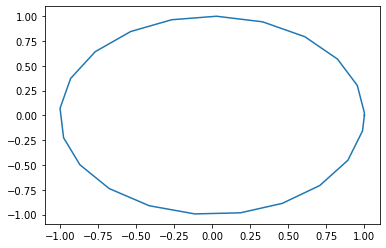

In [103]:
sol = solve_ivp(func, [t0,tf], y0, events = event_func, atol = 1e-6, rtol = 1e-6)
plt.plot(sol.y[0,:],sol.y[1,:])

# Метод пристрелки

In [2]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Метод просто пристрелки

In [3]:
def r2bp(t, y):
    rvect = y[0:3].copy()
    vvect = y[3:6].copy()
    dydt = np.append(vvect, -rvect/np.linalg.norm(rvect)**3)
    return dydt

In [67]:
def residue(x, t0, tf, R0, Rf):
    y0 = np.append(R0, x)
    sol = solve_ivp(r2bp, [t0, tf], y0, method='RK45', atol=1e-06, rtol=1e-06)
    rf = sol.y[0:3,-1]
    f = rf - Rf
    return f

In [71]:
t0 = 0.0
tf = np.pi/2
R0 = np.array([1.0, 0.0, 0.0])
Rf = np.array([0.0, 1.0, 0.0])
x0 = np.array([1/2, 1/2, 0.0])
func = lambda x : residue(x, t0, tf, R0, Rf)
sol = root(func, x0, method='lm')
print('Координаты Rf:', *sol.x)

Координаты Rf: 4.026135261761495e-06 1.0000038133419131 2.3128019987564665e-47


Метод пристрелки с учетом вариационной задачи

In [72]:
def r2bp_var(t, y):
    rvect = y[0:3].copy()
    vvect = y[3:6].copy()
    r = np.linalg.norm(rvect)
    dyd0 = np.reshape(y[6:42].copy(), (6, 6))
    dfdy = np.zeros((6, 6))
    dfdy[0:3, 3:6] = np.eye(3)
    dfdy[3:6, 0:3] = 3*np.outer(rvect,rvect)/r**5 - np.eye(3)/r**3
    dydt = np.empty(42)
    dydt[0:3] = vvect
    dydt[3:6] = -rvect/r**3
    dydt[6:42] = np.reshape(dfdy@dyd0, (36,))
    return dydt

In [73]:
def residue_var(x, t0, tf, R0, Rf):
    y0 = np.concatenate((R0, x, np.reshape(np.eye(6), (36,))))
    sol = solve_ivp(c)
    rf = sol.y[0:3,-1]
    dyfdy0 = np.reshape(sol.y[6:42, -1], (6, 6))
    jac = dyfdy0[0:3, 3:6]
    f = rf - Rf
    return f, jac

In [74]:
def newton(func, x0, maxiter=100):
    iter = 0
    while True:
        iter = iter + 1
        f0, jac0 = func(x0)
        if np.linalg.norm(f0) < 1e-10:
            flag = 0
            return x0, f0, flag
        elif iter == maxiter:
            flag = 1
            return x0, f0, flag
        dx = np.linalg.solve(jac0, f0)
        x1 = x0 - dx
        x0 = x1.copy()

In [75]:
t0 = 0.0
tf = np.pi/2
R0 = np.array([1.0, 0.0, 0.0])
Rf = np.array([0.0, 1.0, 0.0])
x0 = np.array([1/2, 1/2, 0.0])
func = lambda x : residue_var(x, t0, tf, R0, Rf)
sol = root(func, x0, method='lm', jac=True)
sol_newt = newton(func, x0)

In [79]:
print(sol.x)

[7.81457368e-07 1.00000044e+00 0.00000000e+00]


In [81]:
print(sol_newt[0])

[7.81454987e-07 1.00000044e+00 0.00000000e+00]


# Уравнения Шперлинга-Боде

In [1]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp

In [3]:
def r2bp(t, y):
    rvect = y[0:3].copy()
    vvect = y[3:6].copy()
    dydt = np.append(vvect, -rvect/np.linalg.norm(rvect)**3)
    return dydt

In [4]:
def r2bp_sb(s, z):
    rvect = z[0:3].copy()
    wvect = z[3:6].copy()
    r = z[6]
    q = z[7]
    h = z[8]
    Avect = z[9:12].copy()
    t = z[12]
    
    dzds = np.empty((1,))
    dzds[0:3] =  wvect
    dzds[3:6] = 2*h*rvect - Avect
    dzds[6] = q
    dzds[7] = 2*h*r + 1
    dzds[8] = 0
    dzds[9:12] = np.array([0,0,0])
    dzds[12] = r
    
    return dzds

In [5]:
t0 = 0.0
tf = 10 * 2* np.pi
rvect0 = np.array([1.0, 0.0, 0.0])
vvect0 = np.array([0.0, 1.0, 0.0])

tol = 1e-9

y0 = np.append(rvect0,vvect0)
sol = solve_ivp(r2bp, [t0, tf], y0, method='RK45', atol = tol, rtol = tol)

print(np.linalg.norm(sol.y[0:3,-1] - sol.y[0:3,0]))
print(sol.nfev)

2.901276150216712e-06
5048


In [6]:
s0 = 0.0
sf = 1000.0

r0 = np.linalg.norm(rvect0)
v0 = np.linalg.norm(vvect0)
w0 = r0*vvect0
q0 = np.dot(rvect0,vvect0)
h0 = v0**2/2 - 1/r0
Avect0 = -rvect0/r0 + np.cross(vvect0,(np.cross(rvect0,vvect0)))
 
z0 = np.concatenate((rvect0, w0, [r0], [q0], [h0], Avect0, [t0]))

def event_func(s, z, tf):
    return z[12] - tf

eventf = lambda s, z: event_func(s, z, tf)
eventf.terminal = True
eventf.direction = +1

tol = 1e-9

sol_sb = solve_ivp(r2bp_sb, [s0, sf],z0, events = eventf, method='LSODA', atol = tol, rtol = tol)

print(np.linalg.norm(sol_sb.y[0:3,-1] - sol_sb.y[0:3,0]))
print(sol_sb.nfev)

ValueError: could not broadcast input array from shape (3,) into shape (1,)

# Уравнения Куаанхеймо-Штифеля

In [7]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from numpy.linalg import norm
import math as mth

In [8]:
def L_matrix(u):
    L = np.array([[u[0], -u[1], -u[2], u[3]],
                 [u[1], u[0], -u[3], -u[2]],
                 [u[2], u[3], u[0], u[1]],
                 [u[3], -u[2], u[1], -u[0]]])
    return L

In [9]:
def ks2rv(ks):
    u = ks[0:4].copy()
    du = ks[4:8].copy()
    
    L = L_matrix(u)
    
    x = L@u
    rvect = x[0:3]
    
    dx = 2*L@du
    dr = dx[0:3]
    vvect = dr/norm(rvect)
    
    return np.append(rvect,vvect)

In [10]:
def rv2ks(rv):
    rvect = rv[0:3].copy()
    vvect = rv[3:6].copy()
    r = norm(rvect)
    
    u = np.empty((4,))
    if rvect[0] >=0:
        u[0] = mth.sqrt((r + rvect[0])/2) 
        u[1] = rvect[1]*u[0]/(r + rvect[0])
        u[2] = rvect[2]*u[0]/(r + rvect[0])
        u[3] = 0.0 
    else:
        u[1] = mth.sqrt((r - rvect[0])/2) 
        u[2] = 0.0
        u[0] = rvect[1]*u[1]/(r - rvect[0]) 
        u[3] = rvect[2]*u[0]/(r + rvect[0])
    
    L = L_matrix(u)
    dr = r*vvect
    du = 1/r/2 *L.T@np.append(dr,[0.0])
    
    return np.append(u,du)

In [11]:
def r2bp(t, y):
    rvect = y[0:3].copy()
    vvect = y[3:6].copy()
    dydt = np.append(vvect, -rvect/norm(rvect)**3)
    return dydt

In [12]:
def r2bp_ks(s,z,h):
    u = z[0:4].copy()
    du = z[4:8].copy()
    r = z[8]
    q = z[9]
    t = z[10]
    
    dzds = np.empty((11,))
    dzds[0:4] = du
    dzds[4:8] = (h/2) * u
    dzds[8] = q
    dzds[9] = 2*h*r + 1.0
    dzds[10] = r
    
    return dzds

In [13]:
def events(s,z,tf):
    return z[10] - tf

In [14]:
t0 = 0.0
tf = 10 * 2 * np.pi

rvect0 = np.array([1.0, 0.0, 0.0])
vvect0 = np.array([0.0, 1.0, 0.0])
y0 = np.append(rvect0,vvect0)

ks0 = rv2ks(y0)
r0 = norm(rvect0)
v0 = norm(vvect0)
q0 = np.dot(rvect0,vvect0)
h0 =v0**2/2 - 1.0/r0

s0 = 0.0
sf = 100.0
z0 = np.concatenate((ks0,[r0],[q0],[t0]))

r2bp_ks_r = lambda s,z:r2bp_ks(s, z, h0)
events_r = lambda s,z: events(s, z, tf)
events_r.terminal = True
events_r.direction = +1

In [15]:
tol = 1e-06
method = 'RK45'

sol = solve_ivp(r2bp, [t0, tf], y0, method=method, atol = tol, rtol = tol)
sol_ks = solve_ivp(r2bp_ks_r, [s0, sf], z0,events = events_r, method=method, atol = tol, rtol = tol)

rv1 = ks2rv(sol_ks.y[0:8,-1])
rv0 = ks2rv(sol_ks.y[0:8,0])

print(f"{norm(sol.y[0:3,-1] - sol.y[0:3,0]):6.6e}")
print(f"{norm(rv1[0:3] - rv0[0:3]):6.6e}")

print(sol.nfev)
print(sol_ks.nfev)

9.794763e-03
5.759005e-05
1244
608


# Переход к равноденствующим элементам

In [16]:
import numpy as np
from numpy.linalg import norm
import math as mth
import random as rd

In [17]:
def eq2rv(eq):
    mu = 1
    
    p = eq[0].copy()
    e = eq[1:3].copy()
    i = eq[3:5].copy()
    L = eq[5].copy()
    
    f = np.empty(3)
    f[0] = 1 + i[0]**2 - i[1]**2
    f[1] = 2*i[0] * i[1]
    f[2] = -2*i[1]
    f *= np.sqrt(mu*p)/(1 + i[0]**2 + i[1]**2)
    
    g = np.empty(3)
    g[0] = 2 * i[0] * i[1]
    g[1] = 1 - i[0]**2 + i[1]**2
    g[2] = 2 * i[0]
    g *= np.sqrt(mu*p)/(1 + i[0]**2 + i[1]**2)
    
    rvec = (f * np.cos(L) + g * np.sin(L))
    rvec *= np.sqrt(p/mu)/(1 + e[0]*np.cos(L) + e[1]*np.sin(L))
    
    vvec = g * (e[0] + np.cos(L))/p - f * (e[1] + np.sin(L))/p
    
    return np.concatenate((rvec,vvec))

In [18]:
def rv2eq(rv):
    mu = 1 
    
    rvec = rv[0:3].copy()
    vvec = rv[3:6].copy()
    r = np.linalg.norm(rvec)
    v = np.linalg.norm(vvec)
    
    Avec = -mu * rvec/r + np.cross(vvec, np.cross(rvec, vvec))
    cvec = np.cross(rvec,vvec)
    c = np.linalg.norm(cvec)
    
    f = np.empty(3)
    f[0] = c - cvec[0]**2/(c + cvec[2])
    f[1] = -cvec[0]*cvec[1]/(c+cvec[2])
    f[2] = -cvec[0]
    
    g = np.empty(3)
    g[0] = -cvec[0]*cvec[1]/(c+cvec[2])
    g[1] = c - cvec[1]**2/(c + cvec[2])
    g[2] = -cvec[1]
    
    eq = np.empty(6)
    
    eq[0] = c**2/mu
    eq[1] = np.dot(Avec,f)/(c*mu)
    eq[2] = np.dot(Avec,g)/(c*mu)
    eq[3] = - cvec[1]/(c + cvec[2])
    eq[4] = cvec[0]/(c + cvec[2])
    eq[5] = mth.atan2(np.dot(rvec,g),np.dot(rvec,f))
    
    return eq

In [19]:
rv0 = np.array([37,79,51.,90.,11.,86.])
eq1 = rv2eq(rv0)
rv1 = eq2rv(eq1)
print('rv0:        ',rv0)
print('rv2eq(rv0): ',eq1)
print('eq2rv(eq1): ',rv1)

rv0:         [37. 79. 51. 90. 11. 86.]
rv2eq(rv0):  [ 8.57629620e+07 -3.36538960e+05  1.10729400e+06 -5.50466726e-01
  2.43683175e+00  2.61340036e+00]
eq2rv(eq1):  [37. 79. 51. 90. 11. 86.]


In [21]:
for i in range(1000):
    rv0 = np.array([rd.uniform(-10, 10) for _ in range(6)])

    eq0 = rv2eq(rv0)
    rv1 = eq2rv(eq0)
    
    eq1 = rv2eq(rv1)
    
    if np.linalg.norm(rv1 - rv0) >= 1e-10:
        print('Problem')
        print(rv0 , ' and ', rv1)
    if np.linalg.norm(eq1 - eq0) >= 1e-10:
        print('Problem',np.linalg.norm(eq1 - eq0))
        print(eq0 , ' and ', eq1)